# Creating a Sentiment Analysis Web App
## Using PyTorch and SageMaker

_Deep Learning Nanodegree Program | Deployment_

---

Now that we have a basic understanding of how SageMaker works we will try to use it to construct a complete project from end to end. Our goal will be to have a simple web page which a user can use to enter a movie review. The web page will then send the review off to our deployed model which will predict the sentiment of the entered review.

## Instructions

Some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this notebook. You will not need to modify the included code beyond what is requested. Sections that begin with '**TODO**' in the header indicate that you need to complete or implement some portion within them. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `# TODO: ...` comment. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions for you to answer which relate to the task and your implementation. Each section where you will answer a question is preceded by a '**Question:**' header. Carefully read each question and provide your answer below the '**Answer:**' header by editing the Markdown cell.

> **Note**: Code and Markdown cells can be executed using the **Shift+Enter** keyboard shortcut. In addition, a cell can be edited by typically clicking it (double-click for Markdown cells) or by pressing **Enter** while it is highlighted.

## General Outline

Recall the general outline for SageMaker projects using a notebook instance.

1. Download or otherwise retrieve the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.

For this project, you will be following the steps in the general outline with some modifications. 

First, you will not be testing the model in its own step. You will still be testing the model, however, you will do it by deploying your model and then using the deployed model by sending the test data to it. One of the reasons for doing this is so that you can make sure that your deployed model is working correctly before moving forward.

In addition, you will deploy and use your trained model a second time. In the second iteration you will customize the way that your trained model is deployed by including some of your own code. In addition, your newly deployed model will be used in the sentiment analysis web app.

## Step 1: Downloading the data

As in the XGBoost in SageMaker notebook, we will be using the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/)

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.

In [1]:
%mkdir ../data
!wget -O ../data/aclImdb_v1.tar.gz http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -zxf ../data/aclImdb_v1.tar.gz -C ../data

mkdir: cannot create directory ‘../data’: File exists
--2020-05-14 15:03:12--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘../data/aclImdb_v1.tar.gz’

../data/aclImdb_v1. 100%[===================>]  80.23M  8.01MB/s    in 14s     

2020-05-14 15:03:26 (5.79 MB/s) - ‘../data/aclImdb_v1.tar.gz’ saved [84125825/84125825]



## Step 2: Preparing and Processing the data

Also, as in the XGBoost notebook, we will be doing some initial data processing. The first few steps are the same as in the XGBoost example. To begin with, we will read in each of the reviews and combine them into a single input structure. Then, we will split the dataset into a training set and a testing set.

In [1]:
import os
import glob

def read_imdb_data(data_dir='../data/aclImdb'):
    data = {}
    labels = {}
    
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}
        
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    # Here we represent a positive review by '1' and a negative review by '0'
                    labels[data_type][sentiment].append(1 if sentiment == 'pos' else 0)
                    
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
                
    return data, labels

In [3]:
data, labels = read_imdb_data()
print("IMDB reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
            len(data['train']['pos']), len(data['train']['neg']),
            len(data['test']['pos']), len(data['test']['neg'])))

IMDB reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


Now that we've read the raw training and testing data from the downloaded dataset, we will combine the positive and negative reviews and shuffle the resulting records.

In [6]:
from sklearn.utils import shuffle

def prepare_imdb_data(data, labels):
    """Prepare training and test sets from IMDb movie reviews."""
    
    #Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    #Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

In [7]:
train_X, test_X, train_y, test_y = prepare_imdb_data(data, labels)
print("IMDb reviews (combined): train = {}, test = {}".format(len(train_X), len(test_X)))

IMDb reviews (combined): train = 25000, test = 25000


Now that we have our training and testing sets unified and prepared, we should do a quick check and see an example of the data our model will be trained on. This is generally a good idea as it allows you to see how each of the further processing steps affects the reviews and it also ensures that the data has been loaded correctly.

In [6]:
print(train_X[100]) # ----> review
print(train_y[100]) # ---> label

Fairly good movie, but not a true story.<br /><br />Rubin "Hurricane" Carter was a notorius liar, a murder and was never found not guilty. New Jersey State just didn't go for it a third time as 20 years had gone. Carter got an offer in 1976: "Pass a lie test and go free". He didn't take it. This film should never have been made, but money talks. A lot of people have unjustly spend their lives in prison and undoubtedly more blacks than white. Why choose a fake story?<br /><br />Jens
0


In [7]:
print(train_y) # --> labels are all 1(positive) and 0(negative)

[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 

The first step in processing the reviews is to make sure that any html tags that appear should be removed. In addition we wish to tokenize our input, that way words such as *entertained* and *entertaining* are considered the same with regard to sentiment analysis.

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import re
from bs4 import BeautifulSoup

def review_to_words(review):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

The `review_to_words` method defined above uses `BeautifulSoup` to remove any html tags that appear and uses the `nltk` package to tokenize the reviews. As a check to ensure we know how everything is working, try applying `review_to_words` to one of the reviews in the training set.

In [10]:
PorterStemmer().stem("movie") # weird way of stemming, movie --> movi

'movi'

In [11]:
PorterStemmer().stem("fairly") # weird way of stemming, fairly --> fairli

'fairli'

In [9]:
# TODO: Apply review_to_words to a review (train_X[100] or any other review)
words = review_to_words(train_X[78]) 
print(words) 

['extraordinari', 'singer', 'care', 'anyth', 'els', 'final', 'scene', 'one', 'best', 'moment', 'show', 'biz', 'bar', 'none', 'glad', 'kept', 'camera', 'ten', 'minut', 'deserv', 'icon', 'statu', 'power', 'voic', 'first', 'saw', 'film', 'five', 'huge', 'impact', 'see', 'today', 'ye', 'see', 'flaw', 'like', 'esther', 'want', 'leav', 'grammi', 'right', 'award', 'announc', 'user', 'comment', 'plain', 'fals', 'mean', 'gratuit', 'nuditi', 'mayb', 'saw', 'differ', 'film', 'streisand', 'sing', 'abil', 'monument', 'big', 'ego', 'fine', 'earn']


**Question:** Above we mentioned that `review_to_words` method removes html formatting and allows us to tokenize the words found in a review, for example, converting *entertained* and *entertaining* into *entertain* so that they are treated as though they are the same word. What else, if anything, does this method do to the input?

**Answer:**
1. Remove html tags
2. change all to lower case
3. remove stop words
4. stem all words (weird stem though, it becomes movi and farli)

The method below applies the `review_to_words` method to each of the reviews in the training and testing datasets. In addition it caches the results. This is because performing this processing step can take a long time. This way if you are unable to complete the notebook in the current session, you can come back without needing to process the data a second time.

In [10]:
import pickle

cache_dir = os.path.join("../cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [review_to_words(review) for review in data_train]
        words_test = [review_to_words(review) for review in data_test]
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test

In [3]:
## The following is a variant of preprocess_data without input, get all data directly without having arguements into function
## This should only be run on second try, when there's a pickle cache file of reprocessed_data.pkl

import pickle
cache_dir = os.path.join("../cache", "sentiment_analysis")
cache_file="preprocessed_data.pkl"
if cache_file is not None:
    try:
        with open(os.path.join(cache_dir, cache_file), "rb") as f:
            cache_data = pickle.load(f)
        print("Read preprocessed data from cache file:", cache_file)
    except:
        pass  # unable to read from cache, but that's okay
train_X, test_X, train_y, test_y = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])

Read preprocessed data from cache file: preprocessed_data.pkl


In [11]:
# Preprocess data
train_X, test_X, train_y, test_y = preprocess_data(train_X, test_X, train_y, test_y)

Read preprocessed data from cache file: preprocessed_data.pkl


## Transform the data

In the XGBoost notebook we transformed the data from its word representation to a bag-of-words feature representation. For the model we are going to construct in this notebook we will construct a feature representation which is very similar. To start, we will represent each word as an integer. Of course, some of the words that appear in the reviews occur very infrequently and so likely don't contain much information for the purposes of sentiment analysis. The way we will deal with this problem is that we will fix the size of our working vocabulary and we will only include the words that appear most frequently. We will then combine all of the infrequent words into a single category and, in our case, we will label it as `1`.

Since we will be using a recurrent neural network, it will be convenient if the length of each review is the same. To do this, we will fix a size for our reviews and then pad short reviews with the category 'no word' (which we will label `0`) and truncate long reviews.

### (TODO) Create a word dictionary

To begin with, we need to construct a way to map words that appear in the reviews to integers. Here we fix the size of our vocabulary (including the 'no word' and 'infrequent' categories) to be `5000` but you may wish to change this to see how it affects the model.

> **TODO:** Complete the implementation for the `build_dict()` method below. Note that even though the vocab_size is set to `5000`, we only want to construct a mapping for the most frequently appearing `4998` words. This is because we want to reserve the special labels `0` for 'no word' and `1` for 'infrequent word'.

In [7]:
## This cell is just workings on how we should do build_dict function
data = [['how','are','you'],['such','a','nice','day','you','me'],['you','are','me']]
from collections import defaultdict
word_count = defaultdict(int)
for sentence in data:
    for word in sentence:
        word_count[word]+=1
# print(word_count)
[k for k,v in sorted(word_count.items(), key=lambda item: -item[1])]

['you', 'are', 'me', 'how', 'such', 'a', 'nice', 'day']

In [4]:
import numpy as np
from collections import defaultdict

def build_dict(data, vocab_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    # TODO: Determine how often each word appears in `data`. Note that `data` is a list of sentences and that a
    #       sentence is a list of words.
    
    word_count = {} # A dict storing the words that appear in the reviews along with how often they occur
    
    # TODO: Sort the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    #       sorted_words[-1] is the least frequently appearing word.
    
    word_count = defaultdict(int)
    for sentence in data:
        for word in sentence:
            word_count[word]+=1
    sorted_words = [k for k,v in sorted(word_count.items(), key=lambda item: -item[1])]
    
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict

In [5]:
word_dict = build_dict(train_X)

**Question:** What are the five most frequently appearing (tokenized) words in the training set? Does it makes sense that these words appear frequently in the training set?

**Answer:** 'movi': 2, 'film': 3, 'one': 4, 'like': 5, 'time': 6, 'good': 7 ## can be seen from first five words below

In [6]:
print(word_dict)

{'movi': 2, 'film': 3, 'one': 4, 'like': 5, 'time': 6, 'good': 7, 'make': 8, 'charact': 9, 'get': 10, 'see': 11, 'watch': 12, 'stori': 13, 'even': 14, 'would': 15, 'realli': 16, 'well': 17, 'scene': 18, 'look': 19, 'show': 20, 'much': 21, 'end': 22, 'peopl': 23, 'bad': 24, 'go': 25, 'great': 26, 'also': 27, 'first': 28, 'love': 29, 'think': 30, 'way': 31, 'act': 32, 'play': 33, 'made': 34, 'thing': 35, 'could': 36, 'know': 37, 'say': 38, 'seem': 39, 'work': 40, 'plot': 41, 'two': 42, 'actor': 43, 'year': 44, 'come': 45, 'mani': 46, 'seen': 47, 'take': 48, 'life': 49, 'want': 50, 'never': 51, 'littl': 52, 'best': 53, 'tri': 54, 'man': 55, 'ever': 56, 'give': 57, 'better': 58, 'still': 59, 'perform': 60, 'find': 61, 'feel': 62, 'part': 63, 'back': 64, 'use': 65, 'someth': 66, 'director': 67, 'actual': 68, 'interest': 69, 'lot': 70, 'real': 71, 'old': 72, 'cast': 73, 'though': 74, 'live': 75, 'star': 76, 'enjoy': 77, 'guy': 78, 'anoth': 79, 'new': 80, 'role': 81, 'noth': 82, '10': 83, 'fu

### Save `word_dict`

Later on when we construct an endpoint which processes a submitted review we will need to make use of the `word_dict` which we have created. As such, we will save it to a file now for future use.

In [15]:
data_dir = '../data/pytorch' # The folder we will use for storing data
if not os.path.exists(data_dir): # Make sure that the folder exists
    os.makedirs(data_dir)

In [11]:
with open(os.path.join(data_dir, 'word_dict.pkl'), "wb") as f:
    pickle.dump(word_dict, f)

### Transform the reviews

Now that we have our word dictionary which allows us to transform the words appearing in the reviews into integers, it is time to make use of it and convert our reviews to their integer sequence representation, making sure to pad or truncate to a fixed length, which in our case is `500`.

In [7]:
def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=500):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [8]:
train_X, train_X_len = convert_and_pad_data(word_dict, train_X)
test_X, test_X_len = convert_and_pad_data(word_dict, test_X)

As a quick check to make sure that things are working as intended, check to see what one of the reviews in the training set looks like after having been processeed. Does this look reasonable? What is the length of a review in the training set?

The following 6 cells are rough working to see how paded works, for first five words

In [26]:
print(['fairli', 'good', 'movi', 'true', 'stori', 'rubin', 'hurrican', 'carter', 'notoriu', 'liar', 'murder', 'never', 'found', 'guilti', 'new', 'jersey', 'state', 'go', 'third', 'time', '20', 'year', 'gone', 'carter', 'got', 'offer', '1976', 'pass', 'lie', 'test', 'go', 'free', 'take', 'film', 'never', 'made', 'money', 'talk', 'lot', 'peopl', 'unjustli', 'spend', 'live', 'prison', 'undoubtedli', 'black', 'white', 'choos', 'fake', 'stori', 'jen'])

['fairli', 'good', 'movi', 'true', 'stori', 'rubin', 'hurrican', 'carter', 'notoriu', 'liar', 'murder', 'never', 'found', 'guilti', 'new', 'jersey', 'state', 'go', 'third', 'time', '20', 'year', 'gone', 'carter', 'got', 'offer', '1976', 'pass', 'lie', 'test', 'go', 'free', 'take', 'film', 'never', 'made', 'money', 'talk', 'lot', 'peopl', 'unjustli', 'spend', 'live', 'prison', 'undoubtedli', 'black', 'white', 'choos', 'fake', 'stori', 'jen']


In [28]:
old = ['fairli', 'good', 'movi', 'true', 'stori', 'rubin', 'hurrican', 'carter', 'notoriu', 'liar', 'murder', 'never', 'found', 'guilti', 'new', 'jersey', 'state', 'go', 'third', 'time', '20', 'year', 'gone', 'carter', 'got', 'offer', '1976', 'pass', 'lie', 'test', 'go', 'free', 'take', 'film', 'never', 'made', 'money', 'talk', 'lot', 'peopl', 'unjustli', 'spend', 'live', 'prison', 'undoubtedli', 'black', 'white', 'choos', 'fake', 'stori', 'jen']
for i,word in enumerate(old):
    if i<5:
        print(word_dict[word])
    else:
        break

928
7
2
205
13


In [33]:
type(train_X[100])

numpy.ndarray

In [41]:
type(train_X)

numpy.ndarray

In [42]:
train_X.ndim

2

In [14]:
# Use this cell to examine one of the processed reviews to make sure everything is working as intended.
train_X[100]

array([ 928,    7,    2,  205,   13,    1,    1, 2711,    1,    1,  250,
         51,  184, 2222,   80,    1,  513,   25,  721,    6,  776,   44,
        743, 2711,  111,  516, 4592,  578,  875, 1475,   25,  784,   48,
          3,   51,   34,  200,  242,   70,   23,    1,  677,   75,  825,
       3421,  247,  364, 1349, 1017,   13,    1,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

**Question:** In the cells above we use the `preprocess_data` and `convert_and_pad_data` methods to process both the training and testing set. Why or why not might this be a problem?

**Answer:** This will not be a problem, words are stem, padded, and converted to indices.  
to add on, logically certain word do not affect the sentiment of a post "the" , "is", "are", etc. So we can remove it from both train and test set

## Step 3: Upload the data to S3

As in the XGBoost notebook, we will need to upload the training dataset to S3 in order for our training code to access it. For now we will save it locally and we will upload to S3 later on.

### Save the processed training dataset locally

It is important to note the format of the data that we are saving as we will need to know it when we write the training code. In our case, each row of the dataset has the form `label`, `length`, `review[500]` where `review[500]` is a sequence of `500` integers representing the words in the review.

In [15]:
import pandas as pd
    
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X_len), pd.DataFrame(train_X)], axis=1) \
        .to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Uploading the training data


Next, we need to upload the training data to the SageMaker default S3 bucket so that we can provide access to it while training our model.

In [9]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/sentiment_rnn'

role = sagemaker.get_execution_role()

In [20]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

**NOTE:** The cell above uploads the entire contents of our data directory. This includes the `word_dict.pkl` file. This is fortunate as we will need this later on when we create an endpoint that accepts an arbitrary review. For now, we will just take note of the fact that it resides in the data directory (and so also in the S3 training bucket) and that we will need to make sure it gets saved in the model directory.

## Step 4: Build and Train the PyTorch Model

In the XGBoost notebook we discussed what a model is in the SageMaker framework. In particular, a model comprises three objects

 - Model Artifacts,
 - Training Code, and
 - Inference Code,
 
each of which interact with one another. In the XGBoost example we used training and inference code that was provided by Amazon. Here we will still be using containers provided by Amazon with the added benefit of being able to include our own custom code.

We will start by implementing our own neural network in PyTorch along with a training script. For the purposes of this project we have provided the necessary model object in the `model.py` file, inside of the `train` folder. You can see the provided implementation by running the cell below.

In [10]:
!pygmentize train/model.py

import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    This is the simple RNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        """
        Initialize the model by settingg up the various layers.
        """
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.dense = nn.Linear(in_features=hidden_dim, out_features=1)
        self.sig = nn.Sigmoid()
        
        self.word_dict = None

    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        x = x.t()
        lengths = x[0,:]
        reviews = x[1:,:]
        embeds = self.embedding(reviews)
        lstm_out, _ = self.lstm(embeds)
        out = self.dense(lstm_out)
        out = out[lengths - 1, range(len(lengths))]
        return self.sig

The important takeaway from the implementation provided is that there are three parameters that we may wish to tweak to improve the performance of our model. These are the embedding dimension, the hidden dimension and the size of the vocabulary. We will likely want to make these parameters configurable in the training script so that if we wish to modify them we do not need to modify the script itself. We will see how to do this later on. To start we will write some of the training code in the notebook so that we can more easily diagnose any issues that arise.

First we will load a small portion of the training data set to use as a sample. It would be very time consuming to try and train the model completely in the notebook as we do not have access to a gpu and the compute instance that we are using is not particularly powerful. However, we can work on a small bit of the data to get a feel for how our training script is behaving.

In [13]:
import pandas as pd

In [16]:
import torch
import torch.utils.data

# Read in only the first 250 rows
train_sample = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None, nrows=250)

# Turn the input pandas dataframe into tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)

### (TODO) Writing the training method

Next we need to write the training code itself. This should be very similar to training methods that you have written before to train PyTorch models. We will leave any difficult aspects such as model saving / loading and parameter loading until a little later.

In [17]:
def train(model, train_loader, epochs, optimizer, loss_fn, device):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:         
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # TODO: Complete this train method to train the model provided.
            optimizer.zero_grad() # Clears existing gradients from previous epoch
            output = model.forward(batch_X)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
        print("Epoch: {}, BCELoss: {}".format(epoch, total_loss / len(train_loader)))

Supposing we have the training method above, we will test that it is working by writing a bit of code in the notebook that executes our training method on the small sample training set that we loaded earlier. The reason for doing this in the notebook is so that we have an opportunity to fix any errors that arise early when they are easier to diagnose.

In [20]:
import torch.optim as optim
from train.model import LSTMClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(32, 100, 5000).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

train(model, train_sample_dl, 5, optimizer, loss_fn, device)

Epoch: 1, BCELoss: 0.6931846499443054
Epoch: 2, BCELoss: 0.6845690965652466
Epoch: 3, BCELoss: 0.6776063919067383
Epoch: 4, BCELoss: 0.6703506588935852
Epoch: 5, BCELoss: 0.6621131539344788


In order to construct a PyTorch model using SageMaker we must provide SageMaker with a training script. We may optionally include a directory which will be copied to the container and from which our training code will be run. When the training container is executed it will check the uploaded directory (if there is one) for a `requirements.txt` file and install any required Python libraries, after which the training script will be run.

### (TODO) Training the model

When a PyTorch model is constructed in SageMaker, an entry point must be specified. This is the Python file which will be executed when the model is trained. Inside of the `train` directory is a file called `train.py` which has been provided and which contains most of the necessary code to train our model. The only thing that is missing is the implementation of the `train()` method which you wrote earlier in this notebook.

**TODO**: Copy the `train()` method written above and paste it into the `train/train.py` file where required.

The way that SageMaker passes hyperparameters to the training script is by way of arguments. These arguments can then be parsed and used in the training script. To see how this is done take a look at the provided `train/train.py` file.

In [18]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 10,
                        'hidden_dim': 200,
                    })

In [21]:
estimator.fit({'training': input_data})

2020-05-17 05:58:46 Starting - Starting the training job...
2020-05-17 05:58:47 Starting - Launching requested ML instances......
2020-05-17 05:59:47 Starting - Preparing the instances for training......
2020-05-17 06:00:50 Downloading - Downloading input data...
2020-05-17 06:01:25 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-05-17 06:01:56,035 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-05-17 06:01:56,059 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-05-17 06:01:59,147 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-05-17 06:01:59,437 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-05-17 06:01:59,437 sagemaker-containers INFO     Generating setup.cfg
2020-05-17 06:01:59,437 sagemaker-containers I

Model loaded with embedding_dim 32, hidden_dim 200, vocab_size 5000.
Epoch: 1, BCELoss: 0.6755489232588787
Epoch: 2, BCELoss: 0.6152689116341727
Epoch: 3, BCELoss: 0.6140984418440838
Epoch: 4, BCELoss: 0.4980376046531054
Epoch: 5, BCELoss: 0.447328690971647
Epoch: 6, BCELoss: 0.3917848017750954
Epoch: 7, BCELoss: 0.53101319317915
Epoch: 8, BCELoss: 0.567303792554505
Epoch: 9, BCELoss: 0.6062574337939827

2020-05-17 06:05:18 Uploading - Uploading generated training modelEpoch: 10, BCELoss: 0.5436752955524289
2020-05-17 06:05:18,079 sagemaker-containers INFO     Reporting training SUCCESS

2020-05-17 06:05:25 Completed - Training job completed
Training seconds: 275
Billable seconds: 275


## Step 5: Testing the model

As mentioned at the top of this notebook, we will be testing this model by first deploying it and then sending the testing data to the deployed endpoint. We will do this so that we can make sure that the deployed model is working correctly.

## Step 6: Deploy the model for testing

Now that we have trained our model, we would like to test it to see how it performs. Currently our model takes input of the form `review_length, review[500]` where `review[500]` is a sequence of `500` integers which describe the words present in the review, encoded using `word_dict`. Fortunately for us, SageMaker provides built-in inference code for models with simple inputs such as this.

There is one thing that we need to provide, however, and that is a function which loads the saved model. This function must be called `model_fn()` and takes as its only parameter a path to the directory where the model artifacts are stored. This function must also be present in the python file which we specified as the entry point. In our case the model loading function has been provided and so no changes need to be made.

**NOTE**: When the built-in inference code is run it must import the `model_fn()` method from the `train.py` file. This is why the training code is wrapped in a main guard ( ie, `if __name__ == '__main__':` )

Since we don't need to change anything in the code that was uploaded during training, we can simply deploy the current model as-is.

**NOTE:** When deploying a model you are asking SageMaker to launch an compute instance that will wait for data to be sent to it. As a result, this compute instance will continue to run until *you* shut it down. This is important to know since the cost of a deployed endpoint depends on how long it has been running for.

In other words **If you are no longer using a deployed endpoint, shut it down!**

**TODO:** Deploy the trained model.

In [23]:
# TODO: Deploy the trained model
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!

## Step 7 - Use the model for testing

Once deployed, we can read in the test data and send it off to our deployed model to get some results. Once we collect all of the results we can determine how accurate our model is.

In [24]:
test_X = pd.concat([pd.DataFrame(test_X_len), pd.DataFrame(test_X)], axis=1)

In [25]:
# We split the data into chunks and send each chunk seperately, accumulating the results.

def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

In [26]:
predictions = predict(test_X.values)
predictions = [round(num) for num in predictions]

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)

0.7722

**Question:** How does this model compare to the XGBoost model you created earlier? Why might these two models perform differently on this dataset? Which do *you* think is better for sentiment analysis?

**Answer:** The accuracy is similar to our XGBoost model. However this is more computationally intensive, so XGBoost is better

### (TODO) More testing

We now have a trained model which has been deployed and which we can send processed reviews to and which returns the predicted sentiment. However, ultimately we would like to be able to send our model an unprocessed review. That is, we would like to send the review itself as a string. For example, suppose we wish to send the following review to our model.

In [28]:
test_review = 'The simplest pleasures in life are the best, and this film is one of them. Combining a rather basic storyline of love and adventure this movie transcends the usual weekend fair with wit and unmitigated charm.'

The question we now need to answer is, how do we send this review to our model?

Recall in the first section of this notebook we did a bunch of data processing to the IMDb dataset. In particular, we did two specific things to the provided reviews.
 - Removed any html tags and stemmed the input
 - Encoded the review as a sequence of integers using `word_dict`
 
In order process the review we will need to repeat these two steps.

**TODO**: Using the `review_to_words` and `convert_and_pad` methods from section one, convert `test_review` into a numpy array `test_data` suitable to send to our model. Remember that our model expects input of the form `review_length, review[500]`.

In [37]:
# TODO: Convert test_review into a form usable by the model and save the results in test_data
temp = convert_and_pad(word_dict, review_to_words(test_review))
test_data = [np.array(temp[0])]

Now that we have processed the review, we can send the resulting array to our model to predict the sentiment of the review.

In [39]:
predictor.predict(test_data)

array(0.455766, dtype=float32)

Obviously it's closer to 0, so it should be negative? maybe something went wrong

Since the return value of our model is close to `1`, we can be certain that the review we submitted is positive.

### Delete the endpoint

Of course, just like in the XGBoost notebook, once we've deployed an endpoint it continues to run until we tell it to shut down. Since we are done using our endpoint for now, we can delete it.

In [40]:
estimator.delete_endpoint()

## Step 6 (again) - Deploy the model for the web app

Now that we know that our model is working, it's time to create some custom inference code so that we can send the model a review which has not been processed and have it determine the sentiment of the review.

As we saw above, by default the estimator which we created, when deployed, will use the entry script and directory which we provided when creating the model. However, since we now wish to accept a string as input and our model expects a processed review, we need to write some custom inference code.

We will store the code that we write in the `serve` directory. Provided in this directory is the `model.py` file that we used to construct our model, a `utils.py` file which contains the `review_to_words` and `convert_and_pad` pre-processing functions which we used during the initial data processing, and `predict.py`, the file which will contain our custom inference code. Note also that `requirements.txt` is present which will tell SageMaker what Python libraries are required by our custom inference code.

When deploying a PyTorch model in SageMaker, you are expected to provide four functions which the SageMaker inference container will use.
 - `model_fn`: This function is the same function that we used in the training script and it tells SageMaker how to load our model.
 - `input_fn`: This function receives the raw serialized input that has been sent to the model's endpoint and its job is to de-serialize and make the input available for the inference code.
 - `output_fn`: This function takes the output of the inference code and its job is to serialize this output and return it to the caller of the model's endpoint.
 - `predict_fn`: The heart of the inference script, this is where the actual prediction is done and is the function which you will need to complete.

For the simple website that we are constructing during this project, the `input_fn` and `output_fn` methods are relatively straightforward. We only require being able to accept a string as input and we expect to return a single value as output. You might imagine though that in a more complex application the input or output may be image data or some other binary data which would require some effort to serialize.

### (TODO) Writing inference code

Before writing our custom inference code, we will begin by taking a look at the code which has been provided.

In [22]:
!pygmentize serve/predict.py

import argparse
import json
import os
import pickle
import sys
import sagemaker_containers
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from model import LSTMClassifier

from utils import review_to_words, convert_and_pad

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMClassifier(model_info['embedding_dim'], model_info['hidden_dim'], model_info['vocab_size'])

    # Load the store model parameters.
    model_path = os.path.join(mod

As mentioned earlier, the `model_fn` method is the same as the one provided in the training code and the `input_fn` and `output_fn` methods are very simple and your task will be to complete the `predict_fn` method. Make sure that you save the completed file as `predict.py` in the `serve` directory.

**TODO**: Complete the `predict_fn()` method in the `serve/predict.py` file.

### Deploying the model

Now that the custom inference code has been written, we will create and deploy our model. To begin with, we need to construct a new PyTorchModel object which points to the model artifacts created during training and also points to the inference code that we wish to use. Then we can call the deploy method to launch the deployment container.

**NOTE**: The default behaviour for a deployed PyTorch model is to assume that any input passed to the predictor is a `numpy` array. In our case we want to send a string so we need to construct a simple wrapper around the `RealTimePredictor` class to accomodate simple strings. In a more complicated situation you may want to provide a serialization object, for example if you wanted to sent image data.

In [23]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     source_dir='serve',
                     predictor_cls=StringPredictor)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------!

### Testing the model

Now that we have deployed our model with the custom inference code, we should test to see if everything is working. Here we test our model by loading the first `250` positive and negative reviews and send them to the endpoint, then collect the results. The reason for only sending some of the data is that the amount of time it takes for our model to process the input and then perform inference is quite long and so testing the entire data set would be prohibitive.

In [24]:
import glob

def test_reviews(data_dir='../data/aclImdb', stop=250):
    
    results = []
    ground = []
    
    # We make sure to test both positive and negative reviews    
    for sentiment in ['pos', 'neg']:
        
        path = os.path.join(data_dir, 'test', sentiment, '*.txt')
        files = glob.glob(path)
        
        files_read = 0
        
        print('Starting ', sentiment, ' files')
        
        # Iterate through the files and send them to the predictor
        for f in files:
            with open(f) as review:
                # First, we store the ground truth (was the review positive or negative)
                if sentiment == 'pos':
                    ground.append(1)
                else:
                    ground.append(0)
                # Read in the review and convert to 'utf-8' for transmission via HTTP
                review_input = review.read().encode('utf-8')
                print(review_input)
                # Send the review to the predictor and store the results
                temp = predictor.predict(review_input)
                print(temp)
                #print(temp.decode('utf-8'))
                #print(float(temp.decode('utf-8')))
                results.append(int(float(temp.decode('utf-8'))))
                
            # Sending reviews to our endpoint one at a time takes a while so we
            # only send a small number of reviews
            files_read += 1
            if files_read == stop:
                break
            
    return ground, results

In [25]:
ground, results = test_reviews()

Starting  pos  files
b'I just saw this film at the phoenix film festival today and loved it. The synopsis was listed in our program as "an old Shakespearean actor invites his three children to his suicide party". I wasn\'t sure if I was going to see it because when I read about it I liked the idea of a "suicide party" it sounded very interesting to me, but "old Shakespearean actor" had me worried that the film would be kind of dry and boring. But I decided to give it a try. I am glad that I did. It was not dry and boring in the least, that dialogue was great, funny in a clever way, but not pretentious and difficult to understand. Peter Falk was terrific in this role, he stole the show. I also was pleasantly surprised by Laura San Giacomo\'s performance, usually she bugs me, but I enjoyed watching her in this film very much. I think Judge Reinhold\'s part could have been done better by another actor, at times he seemed kind of cheesy and it looked like acting, not like you were just wat

b'1.0'
b'Since the past couple of days I\'m really hooked on the "Female Scorpion" series and I keep hitting myself over the head because I waited until now \xc2\x96 which is way too long \xc2\x96 before purchasing the whole box set. "Beast Stable" is the third brilliant effort in a row, and the undeniably main trump of this series is how the writers always came up with something entirely new and different for each installment. Never before, or after, has there been an exploitation series that offered so much variety when it comes to story lines, settings, themes and filming styles. The original more or less qualified as a so-called "Women-in-Prison" flick (but already an atypical one), but you can\'t possibly categorize parts 2 and 3 as such, since they hardly feature any footage within prison walls. And the overall tone and atmosphere keeps changing with each new episode as well. The first film was harsh and gritty, whereas the second was psychedelic and part three is almost mainly m

b'1.0'
b'A short review without any spoilers follows.<br /><br />I saw this movie yesterday at the Cannes Film Festival. My initial reaction is one of wonder and happiness. I\'m so happy films like this are being made in our age of blockbusters. <br /><br />Roy Andersson\'s new movie "You, The Living" is nothing less than a complete masterpiece. You, The Living is composed by some 50 vignettes filmed with a static camera. I will not give away the content of the scenes here, because I hate when people spoil even the smallest details. But, yes, most of the scenes made the 1000 people in the Claude Debussy theatre absolutely baffled and amazed. When the film was over we applauded for several minutes, we had no other choice.<br /><br />So what\'s the score with "You, The Living". Hm, Andersson isn\'t afraid to take on the heavy questions; History, guilt, gand The Holocaust during WW2 are big subjects (and these themes work very well together).<br /><br />The images created are brilliant, t

b'1.0'
b'I haven\'t seen this movie in 30 years so I don\'t know if I would like it as much as I did when I was 12. At the time, however, I loved this movie. This is a great "starter chick-flick" for young pre-teen girls. Be careful of the ending, though. There are tears and harsh emotions.<br /><br />Looking back at it from a 2008 perspective (with so much more knowledge of child psychology, politics and political correctness), I think it would be interesting to watch again. Patty\'s uncaring, abusive father, indifferent mother and favored sister all contributed toward making her vulnerable and starving for companionship. Patty was sad when Anton left. She was heartbroken when he was killed. The rage that was directed toward her afterward was shocking. After all, she was only 12 years old.<br /><br />The thing that I most strongly retained is how this movie taught me even "enemy" soldiers are people too. Not all German soldiers were hateful Nazis. When I was older, I saw TV shows like

b'0.0'
b'"A Slight Case of Murder" is an excellent TV movie, which is defiantly worth the price of a rental. William H. Macy is great as a movie critic who accidentally kills his mistress, and then has to try to conceal the crime. Although that may sound dark, the film is actually quite light hearted and funny, with many memorable lines ("Acting is harder than I thought- you ever see BODY HEAT? I think I owe Bill Hurt an apology" and my personal favourite "For next week answer these two questions about film noir, What do these people do during the day? and Why is it always raining?). The film has a great supporting cast including Macy\'s real life wife Felcity Huffman, James Cromwell and Adam Arkin. A must see for Macy fans!'
b'1.0'
b'As most people I am tired of the by the numbers clich\xc3\xa9d movies that Hollywood makes. There seems to be no creativity in Hollywood. Companies only want to spend money on remakes are sequels that have an audience built in.<br /><br />This movie is a 

b'1.0'
b"Surface was awesome, I don't know how many Mondays I survived at school just by thinking about the new episode of surface. I loved it, sometimes I had to call home and tell my mom to tape it for me. I was pretty upset when I heard it was cancelled, I mean jeez way to let us hang. So,they can have their new Tina fay comedy(you couldn't pay me to watch that, I think seeing the commercials made me dumber). I'm gonna miss my Monday night fix of Surface, even if my sister did make fun of me. although,kidnapped does look good and, they still have L&O: SVU (i think, i still have to check) (i only wrote the 2 lines above, because they said i needed ten lines)."
b'1.0'
b"This is my all time favorite Looney Tunes cartoon. It's a common plot: Daffy Duck tries to convince Elmer Fudd that it is really rabbit season and shoot Bugs. But your can never outsmart that rabbit! In addition to usual cartoon comedy, this cartoon is supported by great word play that will keep you rolling on the floo

b'1.0'
b'<br /><br />Oh my word!! I have never seen a film so lacking in any kind of moral judgement or consideration for anything other than the death of the scum! Michael Winner here makes a valid observation of human desires in displaying a gung-ho troth world of deep and damaged execution. Not only does he spoon feed us with utter hell on earth seen through the face of the moustached Bronson, but he also shows us the spoon he\'s feeding us with and says "look at what your watching now look at your self and ask the question: Are you enjoying this?" And even though you\'ll tell yourself NO IT CAN\'T BE!!!! You\'ll know that deep down inside you\'ll know...it\'s a masterpiece'
b'1.0'
b"Lost has been one of the most mesmerizing and thrilling experience I've ever seen. Not only it's the mother of coincidence, but also every time that you think you can set up the whole puzzle in your head, the story takes a completely new direction.<br /><br />Take this casualty for example, The US marin

b'1.0'
b'This movie is not the scariest of all time, but it is a great example of a campy eighties horror flick -- low budget, no stars, lots of inventive death scenes, and enough nudity to keep the teenagers in their seats. The premise is interesting and fun and the three evil kids play their parts well. A nice starting point for "Just Say" Julie Brown exposing her talents early in her career. This film won\'t be seen by many, but for fans of 80\'s horror it\'s a must.'
b'1.0'
b'I went into "Night of the Hunted" not knowing what to expect at all. I was really impressed.<br /><br />It is essentially a mystery/thriller where this girl who can\'t remember anything gets \'rescued\' by a guy who happens to be driving past. The two become fast friends and lovers and together, they try to figure out what is going on with her. Through some vague flashbacks and grim memories, they eventually get to the bottom of it and the ending is pretty cool.<br /><br />I really liked the setting of this on

b'1.0'
b'A true comedy.The dialog is fast and very witty.Eleanor Parker at her physical peak .Flynn as only Flynn can be"the charming rogue\'..although now past his prime.. Most of the scenes between the principals are short so the movie moves well. If you haven\'t seen this movie please give a look.You will be surprised at Flynn\'s comedy timing.The scenes between him Tucker, Parker and "Cudddles" Sakal are hilarious.Just on the basis of the outfits worn by the most attractive Parker,this movie is worth a look.The romance of this 40\'s movie will not be lost on those so inclined to watch movies from Hollywood\'s golden past. My bet is that Never Say Goodbye won\'t disappoint.'
b'1.0'
b'I\'m sure all of the Canadians on IMDb are all too familiar with Canadian content, and how much of it is... well, shall we say, lackluster. There are a select few Canadian shows that are actually worth watching, however, this is definitely one of them.<br /><br />Simple premise. Two guys picking up girl

b'0.0'
b"The movie was surprisingly wonderful especially considering the last sequel. The third was dark, and semi-interesting but it wasn't nearly as fun or enjoyable as this. It is filled with comedic lines about Martha Stuart, doll's anatomy, masturbation, and it was actually done effectively during gruesome and disturbing images. The movie wasn't scary or suspenseful and I'm sure that it wasn't the director's intention. It was fun because of the silliness, Jennifer Tilly's over the top and sexy performance. The puppetry of the dolls were so well handled, the movement of mouth, lips, tears in eyes, knife in chest, and the costumes. The dolls were just marvelous and it made the gruesome deaths more enoyable considering the fact that they were done by wonderful dolls. The new Chucky look was great and Tiffany was very cute. A few scenes with Chucky hugging the human Tiffany even made my father smile. Jesse and Jade were surprisingly well- very attractive and the special effects were c

b'1.0'
b'The movie ". . . And The Earth Did not Swallow Him," based on the book by Tomas Rivera, is an eye-opening movie for most people. It talks about the exploitation that migrant farmworkers go through in order to survive.<br /><br />Sergio Perez uses impressionistic techniques to depict Rivera\'s story. He uses sienna and gray-scale effects to depict some of the scenes, and he uses specific photographic techniques to make the scenes look like they took place in the 1950s.<br /><br />Perez also gives life to the film by using time-appropriate music, including balladeering and guitar playing.<br /><br />I feel that it is a good film to view because it shows in detail how migrant farmworkers live, what they do for entertainment, and their beliefs.'
b'1.0'
b"I go to the movies to be entertained. I was very entertained by the first film in this series: The DaVinci Code. It had plenty of twists and turns throughout to keep me very interested. Angels and Demons is no different. If you en

b'1.0'
b"Reading some of the other reviews of this film, i was reminded of both good and not so good aspects of it. But overall, i have to say it is one of the better films i have seen from any number of genres or countries recently. More than anything else, it avoided many of the typical traps of more recent international cinema, like taking nice pictures of landscapes or being 'hip', 'fun' or imitating American films like pulp fiction. The film is unique in many ways. For one thing, it is a film about relationships in which sex plays no role (unusual, especially for foreign films). It is also a film about two men's relationship to each other (also unusual - not a 'buddy film', no homosexual tension, no ego/phallic competition). It uses little dialogue, but communicates a tremendous amount. It is a simple story, yet full of complex details which are easily understood by any human being and universal in their relevance. I did not find the film dark or depressing (everything would seem 

b'1.0'
b'I am sligthly biased because I appear in this film but i loved it and I am only in about seven dispersed minutes and am not nearly the most interesting part of it. The film is an honest and intriguing account of a noble independent group of filmmakers trying to make a lovable movie. It is also an account of bloated expectations and fallen heros The interviews are well patched together in the editing. The different people are all interesting and there is never really too much of one person. Also, the interviews are shot in a pretty interesting fashion keeping the film visually satisfying. Definitely a worthwhile film. I hope it gets around.'
b'1.0'
b"The Battleship Potemkin is now the oldest film I've seen and it is also the first silent film I've seen. I heard a lot of good things about this movie so I got the tape out at home and I watched it. When it ended I just thought that this was a classic masterpiece. The story is based on the real-life Russian Battleship Potemkin. You

b'0.0'
b'There are some movies that are loved by almost everyone who you come across and yet happen to be box-office failures. Andaz Apna Apna, an intelligent and hilarious comedy falls in that catogory. For once, an Indian director has kept in mind the sensibilities of the audience, and not churned out a Kader Khan type stereo-typical hoax. The movie is about two guys who dream of riches, and try to accomplish that by wooing a millionaire\'s daughter. A humorous drama unfolds while a lot of complexities surface in the story. The complexities add to the sheer comedy of the entire plot. Aamir Khan plays the a street-smart guy, while Salman Khan gives an unexpectedly good performance as the dumb guy. The villian played by Paresh Rawal,and his henchmen, Junior Ajit and "Kaliaa" make you laugh in your sleep. Although the movie borrows from a lot of other movies, despite shoddy camerawork, and despite being "loud" at times, it remains one of the scarce "funny" movies Bombay has come up with

b'1.0'
b"This film, with only two characters, takes you closer to these two people, the interrogator and the prisoner, than most films take you to any character, however well-crafted.<br /><br />The sheer confusion, terror and pain which Madeleine Stowe's character undergoes is deeply disturbing, as is Alan Rickman's sadistic yet charming interrogator.<br /><br />This film is all too possible, and builds to a shocking climax, the effect of the film as a whole leaving you sitting in silence at the end. It'll haunt you for a long time."
b'0.0'
b"First of all - I hardly ever watch Swedish movies, and this is actually the second time in my life I watch a Swedish movie on cinema! Therefor, I believe it's one of the best Swedish movies ever! The combination of thrill and humour is OUTSTANDING, and sometimes you don't even know if you should be terrified or just laugh! The plot is about this man, a writer who wants to go to Germany after World War II and help the Germans to start over. On the

b'1.0'
b'"Please, don\'t kill me! I\'m just an actor!" "Can you play dead?" It\'s difficult to describe this show. It\'s like a crime dramedy. Where the bad cop is an ass. Literally. What\'s great about the show is some of Assy\'s perfectly awful one-liners. Cracking out such gems as "Adios, Blimp," Assy Mcgee provides some great laughs at points. Sadly at other times, the show seems to drag along at a slow pace, making it almost hard to watch. This is definitely the kind of show you\'ll love or hate, there\'s essentially no middleman. It\'s not the best show on {Adult Swim}, but it has some strong points. It\'s worth looking into just to see if you enjoy it. I know I did.'
b'0.0'
b'I rented this obscure aussie relic a few years ago to show at a friend`s place and it was an instant success.The classic tale of the wizard of oz with a decidedly cornball 70`s australian twist.The acting isn`t exactly shakespeare society stuff here,but later ,"Mad max"star Bruce Spence is a beautifully und

b'1.0'
b"This is a very good black comedy, with a great view on how different people have a different perception of the same situations. The three main characters each met a girl named Jewel, played by Liv Tyler, who is a different male fantasy for each of the three men. Each of the three men go through the same situations, but when they tell of them to other people, their perception of the situation is very different from what the other two say. That is a very good concept, probably not entirely original but it works very well in the movie. The plot is very good, very bizarre and extreme, which makes it a good black comedy. The acting is equally good, not one of the actors seemed out of place or out of their league. The comedy is very black, pitch black in some scenes, and a lot of people will definitely be offended by it, but fans of black comedy will probably enjoy it. Overall, this movie is not for everyone's taste, but most people who like black comedy will probably love it, as it

b'1.0'
b"Favela Rising is a documentary about the slums of Rio, the favelas, specifically the most violent one, Vig\xc3\xa1rio Geral. According to this film, a lot more kids have died violently in Rio's favelas over the last decade or so than in Israel/Palestine during the same period -- a fact astonishing if true, which shows how under-recognized this social problem is in the rest of the world. This is an important topic, especially for those who see hope in grassroots efforts to marshal the neediest and most at risk through a vibrant cultural program. This is a compelling documentary, if occasionally marred by a somewhat too personality-based version of events and by grainy digital video and film that sometimes may make you think you need to have your eyes examined.<br /><br />Drug lords rule in the favelas and gun-toting teenage boys are the main drug dealers, like in parts of Colombia. Fernando Meirelles' movie City of God/Cidade de Deus has been accused of celebrating violence (Ci

b'1.0'
b"When Northfork debuted at the Cannes Film Festival, many people didn't like it because they felt it was boring and too slow. While I agree that it was slow (one of the slowest movies of the year), in no way was it boring. As Roger Ebert said, `there has never been a movie like Northfork.' I usually don't agree with Ebert, but for once he speaks the truth. Although John Sayles' Sunshine State may have some of the same immediate themes, nothing that I have ever seen or known of can even compare to the striking originality of the Polish Brothers' Northfork.<br /><br />Northfork is a perfect example of how many times it's better to trek an extra few minutes to go to an art-house film instead of the latest Jack Black movie. The plot isn't some hackneyed, cookie-cutter plot; it's just so strikingly original. A small town in Montana named Northfork has a dam nearby that is about to be taken down. Therefore, the entire town must be evacuated. Some people, however, just don't want to l

b'1.0'
b'CAUTION: Potential Spoilers Ahead!<br /><br />"Steven Spielberg Presents Tiny Toon Adventures" was always one of my favorite cartoons growing up (heck, it still is). And this movie perfectly captures everything I love about the show and puts it in full-length form.<br /><br />Beautifully animated by the Tokyo Movie Shinsa studio (WB outsourced every "Tiny Toons" project, and this was the best studio to handle the show), the movie starts at the end of the school year at Acme Looniversity, the renowned cartoon college where Buster and Babs Bunny (no relation) and their teenage toon peers learn from the masters of animated lunacy, the Looney Tunes. After the final bell, the movie splits off into five different plots. Buster engages Babs in a water gun fight that culminates with a bursting dam and a tidal wave, sending Buster, Babs, and Elmyra\'s dog Byron downriver on an overturned picnic table in search of adventure in the deep South. Plucky Duck talks Hamton Pig and his family 

b'1.0'
b'My buddies and I spent the majority of a Saturday afternoon watching a selection of "bad" movies. Among the flicks we watched, the strongest contender (for quality bad-movie fare) was easily Jack-O. It\'s ludicrous that movies such as "Gigli", "Glitter" and "You Got Served" are listed in IMDBs bottom 100. While they\'re certainly bad movies, they don\'t belong in the bottom 100. They\'re robbing "Jack-O", and "Keeper of Time", etc, of the Bad Movie Greatness they so richly deserve.<br /><br />So what makes Jack-O so great (in bad movie terms)? For starters, Steve Latshaw, the director, decided to cast his son, Ryan Latshaw, in the role of Sean Kelly. Unfortunately for Steve, Ryan Latshaw was dangerously close to being out-acted by a block of wood. The kid, seriously, has no ability to emote whatsoever. The end result: unintentional comic gold. The kid could be listening to a joke, or just moments away from getting his head smashed asunder, and his expression is one of stony "e

b'1.0'
b'I liked this movie. Unlike other thrillers you learn to know the killers very well. You also get to know the two detectives hunting them. The killers are two high school kids. They are very intelligent and want to prove they are smarter than the police so they plan the "perfect crime". We all know this crime will not turn out perfect. What we don\'t know is if they will be caught, or may be just one of them, or even none. In a way I kind of hoped they both would get away with it, although I don\'t know if this was the movies intention.<br /><br />The story is told in a nice way. You are starting to get to know the people involved. The character of Sandra Bullock is likable but has her own secret, which works against her. Ben Chaplin is pretty good as Sam and the two kids are both great. The scenes between them are the better scenes in the movie.<br /><br />I think you can say the movie is pretty good and not as predictable you would think. For a nice evening with a movie, \'Mu

b'1.0'
b'Even a bad Julie Andrews Musical is worth watching and this isn\'t bad! In fact it\'s quite entertaining. Actually it\'s a fascinating study on trying to manipulate a star\'s personae.<br /><br />To break Julie\'s "goody two shoes mold" she plays a German Spy/English Musical Hall Actress. She subsequently went on to take her top off in the movie S.O.B. and play a drag queen in Victor Victoria and other not so goody girls usually under hubby Blake Edward\'s direction.<br /><br />The movie is admittedly problematic It is hard to feel for her character because she\'s a German Spy. We want to love Julie but she\'s on the wrong side of the law. Probably this is why this movie flopped. Julie as a German Spy? Our Mary Poppins? our Maria Van Trapp suddenly a German Spy?<br /><br />The romance seems to happen overnight and come from nowhere. But never mind, it\'s a musical and it has Jullie. Oh and did I mention hunky Rock Hudson is in it too?<br /><br />Julie gives a glowing wonderful

b'1.0'
b"The one thing I really can't seem to forget about this movie, is its beginning: classic comedy, brilliantly crafted. I love it. See it for yourself (no spoilers here! :-). The sparring between DeVito and Crystal also glows in this movie, with DeVito as the perfect oppressed son. One of my favourites. Highly recommended for fans of Crystal."
b'0.0'
b"Nigel Balchin's maze-like novel 'A Way Through the Wood' has been adapted by Julian Fellowes who also directs this 'terribly British' drawing room suspense piece. It is a film whose effect relies on the cast portraying the varyingly benign/malignant characters and it is here that Fellowes' directorial choices are superb. The story has a linear line that is easy to follow, but the beauty of the film is the metamorphosis of each player as a single incident ignites a minefield of disasters.<br /><br />James Manning (Tom Wilkinson) is a successful business obsessed solicitor in London, married to Anne (Emily Watson) who needs more in h

b'1.0'
b'When a saboteur blows up a controversial government research lab, two experimental animals are loosed in a small community in Washington State. One is a dog with unusual intelligence. The other is an "Outside eXperimental COmbat Mammal", or "OXCOM". Because of reasons divulged further into the film, the oxcom hates the dog, and so is trying to kill it. Watchers concerns the accidental involvement of Travis Cornell (Corey Haim), his mom Nora (Barbara Williams) and his girlfriend Tracey (Lala Sloatman) with the dog and oxcom, as two National Security Organization agents, Lem Johnson (Michael Ironside) and Cliff (Blu Mankuma), track them down.<br /><br />Many comments are made about Watchers being very different than the Dean Koontz book that serves as the launching pad for the film. This is true. But it should not affect your rating. If you want the book, read the book. Judge the film on its own merits, not how closely it matches the book. Bill Freed and Damian Lee, who wrote th

b'it\xc2\xb4s a movie to see on tv and only once.. i mean, it\xc2\xb4s good, but it\xc2\xb4s a little too lengthy and the plot is so well-known, it isn\xc2\xb4t very original but it isn\xc2\xb4t boring. the best thing of the movie are the performances, natalie portman and susan sarandon are great actress and in this movie they have done a great job. i give it a 7.'
b'1.0'
b'The one thing that can be said about RUNNING OUT OF TIME is that it\'s an immensely clever film. It\'s interesting to note that the film\'s writers are French, which may explain the movie\'s "out of the norm" vibe, as it doesn\'t really fit in with what is commonly called "Hong Kong Cinema".<br /><br />The movie concerns a thief who plans revenge on some criminal types using the assistance of an equally clever cop. But first he has to convince the cop to join his personal crusade, and so begins a series of games where the thief manuevers the cop into his plan.<br /><br />Quite a clever movie.<br /><br />7 out of 10<

b'1.0'
b'Debbie Vickers (Nell Schofield) and Sue Knight (Jad Capelja) want to become one of the cool girls in their high school. Uncool and ugly girls had two options, be a mole or a prude! Debbie and Sue imitate them by using their cheating practices in an exam. Two of the cool boys, Garry (Goeff Rhoe) and Danny (Tony Hughes) ask them for their answers and they all get busted. After a bawling out from the headmaster (Bud Tingwell) the cool girls meet them outside in the playground and confronted them about whether they "dobbed" on them all. As Debbie and Sue hadn\'t the cool girls invited them to the "dunnies" for a smoke. They then start to hang with them on weekends at the beach, watching all the boys surf. Sue ends up going out with Danny and Debbie with Garry. A lot of usual teenage action takes place including sex, drugs and rock and roll. Garry has an eventual overdose of heroin which makes Debbie face the inequalities of life and she decides to learn to surf instead of just wat

b'1.0'
b"I watched this movie thinking it was going to be absolutely horrible and was ready for all the corniness, bad special effects, etc. But, I was pleasantly surprised. Not to say that it's the best vampire movie I have ever seen, but it certainly isn't the worst. I liked the whole alternate reality/dream state that played into the movie. The graphics were quite well for a straight to DVD movie and I liked the overall look of the film. I enjoyed the main character Sai. I usually end up hating the female leads but there was something about her that kept me interested. Yes, she does make some bad decisions, but that was to be expected. Yes, the other characters were stereotypical, but I was expecting that too. I don't know if I'd highly recommend this movie, but give it a chance and you might be pleasantly surprised. I'm putting this one on my guilty pleasures list."
b'1.0'
b'I\'m not really sure what to make of this movie, especially after seeing a great film like La Notte. Unfortu

b'0.0'
b"I saw Bandit Queen in 2005, over a decade after it was made amidst widespread controversy in India. The language, the stark treatment and the natural acting (by a relatively unknown cast for that time) might have been even more shocking at that time for an Indian populace more familiar with fantasy cinema. The film, the cast, and Shekhar Kapoor, deserve accolades for the breakthrough effort.<br /><br />The plot is not very different from a typical revenge drama made in various forms in India. In fact, there have been several fictional accounts of this particular story itself. The reason why this stands out is that it's supposed to be a first person account of someone who actually went through all this, and a lot else that doesn't find place on the screen, and survived to tell the tale. Survived long enough to see her story made into a movie at least. Phoolan Devi didn't live very long after being released from prison in 1994.<br /><br />The film scores on several counts. The c

b'1.0'
b"Right, here we go, you have probably read in previous reviews on this film that it is awful, badly acted, avoid at all costs. Well i suppose in some ways this is true, it is fair to say that you couldn't write a spoiler in this comment as there is no plot to spoil. However, there is a fine line between plain awful and absolutely hilarious and believe me this film is the latter. The acting is so bad, the plot so non existent and the ending so completely baffling it will have you laughing the whole way through. There are scenes in this film that take comedy to a new level. Do not expect an Oscar winner but believe me for the small price you will pay for this disaster, it is worth every penny."
b'1.0'
b'"Opera" is one of the greatest achievements in horror genre. This masterful picture has everything what should be in the pure horror movie:good, captivating story, a lot of symbols, wonderful visuals and plenty of gore. The killings are very shocking and bloody. An unforgettable a

b'0.0'
b'Having seen the movie years ago and been disappointed by its squandered potential, when I heard that it was becoming a TV series, I flatly refused to watch it. My best friend became a rabid fan immediately, and knowing my love for horror movies, could not believe that I wouldn\'t watch a single episode. I told him that the movie had scarred me for life as far as anything BUFFY was concerned, and he told me to forget that the movie even existed. He insisted that I give two episodes a shot: "Once More With Feeling" and this one.<br /><br />Both of them are why I am a BUFFY fan today. He was right - I was hooked immediately. I have never seen a show with the guts to dare try an episode that has next to no dialogue, and nothing else could\'ve pulled it off with the panache and the pure creativity of BUFFY. I think X FILES might\'ve gotten away with it if they\'d thought of it first, but I\'m glad that BUFFY did it instead. <br /><br />It is a credit to everyone involved that you a

b'1.0'
b'Chucky (the murderous doll from "Child\'s Play" and 2 crappy sequels) is dead. But his ex-girlfriend Tiffany (Jennifer Tilly) gets his remains and (using "Voodoo for Dummies") revives him. Then, through circumstances too convoluted to get into, SHE is killed and has her soul put into another doll! Together they fall in love and kidnap a nice couple (Nick Stabile, Katherine Heigl) to take them to Chuck\'s coffin to get an amulet to make Chucky and Tiffany real people again...<br /><br />A lot better than it sounds. After the last two sequels to "Child\'s Play" (both of which were horrible) I was expecting the worst, but this actually was lots of fun. The movie doesn\'t take itself seriously for a second (seriously--how could it?) and the lines and situations are actually quite funny. Also there are a few VERY gory murders thrown in to satisfy us horror fans and the film never stops moving. The movie also has a few things usually not found in a horror movie--a gay best friend (G

b'1.0'
b'A real surprise. Not exactly family entertainment from "Disney". Some violence, lots of tense moments, and a great story, based on fact. The theme of "Night Crossing" is, determination wins. Never losing sight of their objective, two East German families risk it all, in their daring balloon escape to freedom. The story is both harrowing and heartwarming. Time is not on their side. The East German Police are closing in and the outcome far from certain, until the very end. If you are looking for a good evenings entertainment, that contains no nudity, and limited violence, then I highly recommend "Night Crossing". It is pure entertainment. - MERK'
b'1.0'
b"This film is good in it's genre and that genre is naturally action with a little/average budget. Looks like Van Damme delivers greatly better performances when he has a good director guiding him. There is your basic bar brawl, alley scene and mostly a lot of gun fighting. Some basic drama, but nothing too deep. Isaac Florentine

b'0.0'
b'**SPOILERS** The third and mercifully last of the Aztec Mummy trilogy in the fact that the series major star-besides the Mummy- actor Ramon Gay, as Dr. Eduardo Almada, was gunned down by the outraged husband of a woman he was having an affair with on May 28, 1960! Still that didn\'t stop Gay, in him being edited into them from his previous films, from being in a number of future Mexican horror movies made over the next four years after his death.<br /><br />In "Robot vs the Aztec Mummy" we have the once again mad scientist Dr. Krupp trying to get his hands on the Mummy\'s golden breastplate and bracelet in order, by having them deciphered, to find the Aztez treasure that\'s been secretly buried somewhere in modern Mexico City over 500 years ago. "Robot vs the Aztec Mummy" is not much as a movie in itself in that its made up of stock footage of the previous Aztec Mummy films that take up over half of the films running time.<br /><br />After getting introduced to the movie\'s ca

b'0.0'
b'Revisiting old films that you thought were average isn\'t necessarily a good thing. They sometimes get worse. Championed by the Fangoria camp (in Gorezone they labeled it "the scariest film since Texas CHAINSAW"\xc2\x85um, no), LUTHER THE GEEK inexplicably developed a cult following as an "intense" horror picture. Actually, it is just an average stalk and slash\xc2\x85uh, bite film that briefly sets itself aside from the pack by featuring a killer who clucks like a chicken. Yes, clucks like a chicken. To the filmmaker\'s credit, at least they didn\'t make the killer sound like a duck a la THE NEW YORK RIPPER. That would just be silly.<br /><br />Narrative logic is completely abandoned in LUTHER THE GEEK. I\'m not saying that slasher films are abound with reason, but at least in HALLOWEEN Michael Myers escaped. Luther is actually paroled after a lengthy scene where people argue he is reformed, even though he clucks like a chicken and has razor dentures (which he apparently fash

b'0.0'
b'One of my favorite "bum" actors, C. Tom Howell, stars in this tepid remake of WOTW. He runs around a lot, while a CGI-generated spider-like machine goes around killing everyone. The budget for this one obviously was pretty low. It also was one of The Asylum productions. Have you seen any of those? Yikes! I am not sure why anyone would have made this while the big-budget Spielberg version was slaying them at the box office. And if truth be told, neither version is all that hot. The George Pal version from the 1950s remains the best representation of the H.G. Wells novel, primitive special effects and all. Perhaps because Gene Barry was much more convincing in the lead than Howell or Tom Cruise.'
b'1.0'
b'This game was terrible. I think they worked too hard on the visuals and didn\'t do much with the gameplay, which is the most important part. I mean, the visuals look incredible, but is the game really "fun"? NO! I mean it\'s like "hey let\'s jump off buildings" and all I\'m doi

b'1.0'
b"This 3-hour made-for-TV miniseries came home with us from Blockbuster's this weekend. The production company clearly spent a lot of money on sets, costuming (Bridget Fonda, especially), and special effects (including a great Jim Henson talking polar bear & reindeer). They should have spent a bit more money getting a coherent script. The story line was so loose that it really never came together. One can overlook Irish-accented Germans, but not herky-jerky storytelling. With senseless loose ends which included a special guest appearance by the Devil, this one is certainly not destined to be a Christmas Classic. A shame that they wasted good performances by the two female leads."
b'0.0'
b"Let me break down this film for you...<br /><br />The first fifteen minutes are a showcase for terrible special effects. I'm not one to nitpick about special effects, but what you've got to understand is that if you can't afford good special effects, you shouldn't anchor your film around specia

b'0.0'
b'One would think that with all the lavish care and expense that went into this made-for-TV movie, it would reflect something of the taste and manners of the upper class couple--Wallis Simpson and the Prince of Wales--instead of being a mawkish, unappetizing historical romance.<br /><br />Nor is it helped by the fact that JANE SEYMOUR and ANTHONY ANDREWS give stiff, rather uncomfortable to watch performances in which the events move much too slowly to hold attention.<br /><br />It\'s hard to understand why a star of OLIVIA DE HAVILLAND\'s caliber would wish to play the supporting role of Aunt Bessie since the role is so colorless she just about fades out of sight. At this stage in her career, Olivia was appearing in so many "nobility" roles requiring a regal presence but nothing more.<br /><br />A trivial movie best left forgotten among all the made-for-TV movies of that era.'
b'0.0'
b'I finished watching Mandy Lane about an hour ago, and felt the urge to come straight home and 

b'0.0'
b'This has got to be one of the weakest plots in a movie I have ever seen.<br /><br />However, that is not all that this movie is lacking. This movie has the worst acting, writing, directing, special effects, you name it--it\'s the worst ever.<br /><br />I highly advise you to spend your time on worthwhile movies and not waste your time on this garbage.<br /><br />I do agree with an earlier post that the "women" were definitely men dressed up in drag, and that did give me a laugh, I keep trying to figure out if they were being obvious about it or if they were actually trying to be sexy women.<br /><br />Anyway, there is not much else in this movie that is worth watching!<br /><br />To sum it up: horrible acting, horrible script, horrible idea for a movie. An hour and a half of my life I want back RIGHT NOW!!'
b'0.0'
b"Truly, truly awful. I don't even know where to begin. This is a perfect example of a movie that doesn't know what to do with itself. I'm not sure I could even assi

b'0.0'
b'The theatrics and the drama included in the movie is fantastic, but the facts and the research is far from solid. When quoting Dr. Bovon, where the documentary tries to establish a connection to Mary Magdalene from Mariamene, Dr. Bovon later clarifies it should be used for literary purposes (ie: fables of that time) not for a historical figure. In fact he states, he does NOT believe the Mariamene ossuary in Talpiot is Mary Magdalene. He further comments on his public letter, that he was not informed that his words would be used for this documentary but rather for information regarding Acts of Philip (a literary work in the 4th century).<br /><br />So what we have here is a director that took one clip for a 4th century Acts of Philip fantasy and used it specifically to support a 1st century ossuary inscription. A very sad stretch and Dr. Bovon calls the Jesus/Mary Magdalene connection as "science fiction" -- as this documentary should be rightly labeled.'
b'1.0'
b'If you came h

b'0.0'
b"Casper Van Dien... what can I say? I enjoy the guy! His movies bring a certain flair to them that is actually not brought on by the director or producer, but by him! Recycled plots... check. Rip-offs of better movies... check. Wooden acting... check. It's not that Van Dien is a bad actor (he has been effective in Hollywood gloss as Starship Troopers and Sleepy Hollow) he just really has not been offered a script worthy of his talents; and yes, he does have acting talent other than being eye-candy. This movie offers a slight hint of what Van Dien can offer but is bogged down by the production of it all. The script can be better developed (see Oliver Stone's U-Turn). The directing can be better utilized (see Robert Rodriguez's From Dusk Til Dawn). The DP could've made the desert more exotic (see Russ Meyer's Faster Pussycat Faster Kill!). This script is weak because this is something we have seen before many other times so the double/triple-crosses are expected. The direction is

b'0.0'
b'(As a note, I\'d like to say that I saw this movie at my annual church camp, where the entire youth group laughed at it. I bought it when I saw it on a shelf one year later, if only for the humor I derived from a bad attempt at making an evangelical movie.)<br /><br />Lay it Down falls short of many movie fans\' expectations on several different planes. Most of the problems lie within the impersonal acting. Regardless of the nice cars in the film, or the truth in Christ\'s sacrifice for you, as a movie AND witnessing tool, Lay it Down hardly delivers. <br /><br />Most good opinions of the movies are supported by Christians agreeing with the message. While it\'s easy for a Christian to agree with the points delivered, the audience hardly ever witnesses life outside a clich\xc3\xa9. The fighting scene between Ben and his brother is horribly dubbed. And there are at least three blatant typos in the subtitles.<br /><br />I encourage anyone to watch the movie a second time with the

b'0.0'
b'Yes, it might be not historically accurate(actually only 6 soldiers of 9th rota were killed there), and yes, it has some mistakes and exaggeration(bended machine gun? come on! or the that "history lesson" about how Afghanistan was never conquered by anyone - educated Russian officer would know history much better than that - take for example British campaign in Afghanistan). And yes, it does not have multi-million dollars Hollywood-style special effects, but it\'s strongest point in showing soldier\'s life there, their relationships and their feelings when the best friends are being killed in front of their eyes. In my opinion 9ya rota really does a good job showing all those things.<br /><br />Again, movie has it weaknesses, but, in my opinion, it appears to be one of the strongest Russian movie for the past few years.<br /><br />8/10'
b'1.0'
b'I just attended a preview screening of this film. A masterpiece of documentary film-making it was not. Totally absorbed with its subj

b'0.0'
b'"Witchery" might just be the most incoherent and lamentably scripted horror movie of the 80\'s but, luckily enough, it has a few compensating qualities like fantastic gore effects, an exhilarating musical score and some terrific casting choices. Honestly the screenplay doesn\'t make one iota of sense, but who cares when Linda Blair (with an exploded hairstyle) portrays yet another girl possessed by evil powers and David Hasselhof depicts a hunky photographer (who can\'t seem to get laid) in a movie that constantly features bloody voodoo, sewn-shut lips, upside down crucifixions, vicious burnings and an overused but genuinely creepy tune. Eight random people are gathered together on an abandoned vacation resort island off the coast of Massachusetts. The young couple is there to investigate the place\'s dark history; the dysfunctional family (with a pregnant Linda Blair even though nobody seems to bother about who the father is and what his whereabouts are) considers re-opening 

b'0.0'
b'Honest young insurance agent Ronald Reagan (as Eric Gregg) is optimistic, but poor. His wife, scheming Sheila Bromley (as Nona Gregg), longs for the finer things in life. Describing herself as "not weighted down with tons of righteousness," Ms. Bromley begins to spend more money than Mr. Reagan earns. Bromley obtains the finer things in life, but puts the couple in debt. Bromley is a fun shrew.<br /><br />Handsome Reagan attracts other women, like perky clerk Gloria Blondell (as Patricia Carmody); but, he doesn\'t indulge. To pay the bills, Bromley gets tangled up in the insurance fraud racket - which helps get her husband fired. An unemployed Reagan seems to be tempted into a life of crime - will he remain straight up, or get crooked? Clinton Rosemond has an uncomfortable "broken arm" scene.<br /><br />*** Accidents Will Happen (1938) William Clemens ~ Ronald Reagan, Sheila Bromley, Gloria Blondell'
b'1.0'
b'I clicked onto the Encore Mystery channel to wait for the movie I wa

b'1.0'
b'My wife and I enjoy bad science fiction movies. Some movies are so bad they are good. Mansquito was one of those. That one was bad but it had some redeeming qualities. It makes you wonder how a self respecting actor approaches lines like "Hey! Mansquito!"<br /><br />This one is so bad it has now taken its place as our standard for bad. It isn\'t just a bad movie, it really stinks. There was the coed strike force, the "Indian" that rode around in a black cloak and used a SWORD for crying out loud. He shot down a helicopter with an arrow!! <br /><br />We tried to laugh at this movie but there were no points at which it didn\'t rise above pitiful. We couldn\'t come up with any redeeming features except for one. Those were the words "The End"<br /><br />There seemed to be no plot, no character development, and no point to the movie. Someone in Hollywood needs to be fired.'
b'0.0'
b'OK I have to admit that I quite enjoyed House of the Dead despite its well documented failings. This

b'0.0'
b'Mystery Science Theater 3000 would have not been able to bring any redeeming quality to a showing of this "gem." <br /><br />This one is like a cheesy pirate copy of 80\'s porn you could have purchased on VHS from an arcade on 42nd st. before Disney bought the whole smash and closed them all down. <br /><br />But, wait - all the sex scenes have been cut. I challenge anyone to find a worse film. This film could replace water-boarding as a humane method of interrogation. <br /><br />No, I take that back - I would prefer water-boarding. <br /><br />The only credit this movie could earn apart from being the worst movie ever made would be to threaten the middle east into solving its problems under pain of having to watch this movie.'
b'0.0'
b"This is one of those inoffensive and mildly entertaining little movies that strive to make you to like them more. But like so many others, it's material isn't strong enough to successfully fill a couple of hours.<br /><br />The pitch is promis

b'0.0'
b'You have to see this. I could not stop laughing about the stupidities I saw in this movie even late after the event. There is maybe a million of individual mistakes and stupidities in this movie. The acting is bad. The story is so predictable and flat. The effects are like 50 years old. The supposed thriller is nowhere. You will not enjoy the movie, but you will laugh at it and enjoy laughing at it a long time after it. We had a great time AFTER the movie. Truly. Me and my friend spent entire 40mins long bus trip home chatting about this movie like we have seen next Oscar winner. Sadly we were talking about all those bad things we had just seen.'
b'0.0'
b'Another Indian legend you never heard of before is let loose. As the name implies, this is a vengeful wraith who likes to absorb the skeletons of people while they\'re still using them. As usual, ancient burial grounds (can you say, "Poltergeist?") have been disturbed by clich\xc3\xa9d greedy land developers building stuff.<b

b'1.0'
b'After seeing the movie in a class of mine and having a talk with the filmmaker, I found out exactly why the film bombed the way it did. The creators of the movie had no intention to call the film "8MM 2." Originally, the film was called "The Velvet Side of Hell" but was changed at the last minute by Sony Pictures to 8MM 2 without letting the filmmakers have any say in the matter. By doing that, it screwed them out of theatrical releases and doomed it to a straight to video release with minimal advertising.<br /><br />Again, this is from the filmmaker\'s mouths, not mine, so I really can\'t say what is truth, and what is hype.<br /><br />If you look at the film as "Velvet Side of Hell," it isn\'t THAT bad. It isn\'t great, but it is not god awful. It would basically just be a B-movie that likes to show boobs. But as a sequel to "8MM," the film fails terribly.'
b'0.0'
b'Some slack might be cut this movie due to the fact that it was made in 1979. That much said, it really is pret

b'0.0'
b'I remember all the hype around this movie when Aaliyah was killed. Being a fan of Ms. Rice\'s novels, my first thought was "how can they do Queen Of The Damned without doing Vampire Lestat first?"<br /><br />Having finally seen the movie, now I can see how they did it. If you have read these books, imagine taking out the gory parts from Vampire Lestat, cramming Marcus and Marius into one character, and removing everything to do with Lestat\'s beginning (the wolf hunt, his violin playing, the Theatre Of The Vampires, and also Louis, Claudia, and Gabrielle), then in the last 15 minutes cramming in Queen Of The Damned.<br /><br />What we loose is a very important piece of Lestat\'s character. His inner agony of having to kill to live, the fact that he carefully tries to select killers as his victims, and his love-hate relationship with Louis, Armand, Gabrielle, and all the other vampires.<br /><br />Also important to the story is that we loose the "Story Of The Twins", which is t

b'0.0'
b"Talk about creepy. If you really want to sit down and watch this episode where the girl who was in Firefly later on gets kidnapped there's entertainment for you, but only if you like this sort of thing. I don't so I thought, to be frank, this episode was appalling. Thankfully it's one of a few duff episodes in Season 3, and the only Charles Grant Craig episode, so you don't get much of this sort of thing in Season 3. So, overall verdict? Just read the summary at the top. This is a strong contender (Hell Money says hi!) for worst episode of Season 3. To be honest though, I hadn't really expected much. I wish I could Oubliette this episode altogether. That's one thing they got right: the title."
b'0.0'
b"I just got done watching The Edge of Love (by the way, this is one of the worst titles so far this year) and it felt like a chore. Watching Keira Knightly's unlikable, skeleton-looking character made me cringe even more throughout the coarse of the film.<br /><br />It took me fo

b'1.0'
b"The moral of this show is that bad eating habits give people bad hair, bad taste in clothes, bad posture, bad jobs, and on and on. They are obviously miserable and loathe themselves. However, if they learn to eat broccoli, they will be wealthy, successful, and attractive. <br /><br />TLC ought to be ashamed of themselves for this blatant exploitation of parental fears and guilt. If nutrition is really that important, they should be able to develop a show using honest and truthful methods. If they really believed in their computer simulations, I'd like to see them do a double-blind test by finding some 40-year-olds, finding out what their eating and exercise habits were as children, and age-progressing the kids' photos. Then compare to the real things. Hey, that sounds like a project for Mythbusters! Discovery Channel--are you listening?<br /><br />TLC must stand for Tabloid Lies and Cons."
b'0.0'
b'Under no circumstances watch this film. It is terrible for a number of reasons:

b'0.0'
b"SPOILER ALERT<br /><br />A clich\xc3\xa9-riddled film that somehow makes an anti-death with dignity statement, though it attempts to do the opposite. Washington is a paralyzed forensics officer who has been suffering and wanting to die for the past four years (apparently he wrote his huge selling book only a year ago though, so it hasn't all be despair). He arranges for an assisted suicide with his doctor who will return in a week.<br /><br />In the meantime, he helps out on a serial killer case. He recruits the gutsy, I don't wanna do it, but I'm just so good at it, cop Jolie, and they track down impossible clue jumping to highly unlikely conclusions in matters of moments. Hey, that old bolt means that the killer has the millionaire's wife in a steam tunnel by the old Woolworth building. Shyeah, right. It's laughable. Yet no is smart enough to figure out that doctor who's going to assist him is the killer.<br /><br />When he comes to Washington to murder him (ahead of schedul

b'1.0'
b"Where should I begin with this movie. All I know is that it is a mess. Be the script, story, or the actors. First of all, this movie is very disappointing from Salman Khan who gave us a fun Dulhan Hum Le Jayenge and Har Dil Jo Pyar Karega before this. Second Rani is getting really annoying, appearing in every stupid movie since Kuch Kuch Hota Hai (glad Saathiya stopped this nonsense). The story is stolen from The Wedding Singer, but ruins the funny movie. The dialogues are lacking. I may have laughed here and there, but entertained? NO!!! Salman Khan was tolerable in the above mentioned movies, but here he is insane. His character is poorly written. One minute he is poor and next minute you wonder how is he poor. Rani Mukherjee looks like a plain jain and wasn't putting any effort. She luckily redeemed her career with Saathiya because her career was going haywire around this time. Pooja Batra put a little charm here with her looks but it is still not enough. Jackie Shroff is w

b'0.0'
b'I was disappointed with the third film in the "Death Wish" series and wouldn\'t recommend this unless you are really into Bronson. He is his usual self in this one, maybe a bit lighter hearted than in the others; the rest of the cast is good if your watching a movie of the week on T.V. - the whole film has the production value of a bad episode of the A-Team and I like the escapism fun of a show like the A-Team but not on the big screen, even if it is an action movie that doesn\'t claim to be anything to sophisticated. The film takes a while to get going and then when it finally does, it gets out of control to the point of ridiculousness. The plot is something out of an episode of "Highway to Heaven" and Bronson seems like a fish out of water with the majority senior citizen cast and the gun play is so out of control you don\'t even get any satisfaction from Bronson\'s revenge against the bad guys. Skip this and go on to the 4th installment which I highly recommend.'
b'1.0'
b'G

b"Some movies are not for everyone. This accurately describes Igmar Bergaman's movie, Skammen (Shame). At only 18, I still have what I guess you could call a minor form of ADD and well, I watch movies to be entertained. Shame was a movie with a very interesting premise, of trying to convey the effect of war on the common people, it however fell short of accomplishing this for me. I don't know if it was the subtitles, black and white filming, length of the movie, or the fact that it took two hours out of my studying for a huge chemistry test, but I did not enjoy it. I understand it is considered a great movie and very important in the history of cinema, however, I think as my teacher pointed out, not everyone has liked or likes it. I guess I just wish it finished all of its many side plots. Maybe the translation lost something, but I felt there were infinite little off shoots that never met a conclusion. You would meet characters and never see them again, or really understand why they w

b'0.0'
b'Yes, my summary just about tells it all.<br /><br />If you haven\'t watched this, try it. But not for pleasure. For studies of one of the worst examples of trying to be politically correct, family-oriented and "cool" at the same time.<br /><br />The men always think they know everything, are stupid, and finally loose to the magnificent women. Etc.. This is especially offensive, when all the characters are just as terrible and stereotypic. I mean, ok, "Cody" was funny one time or another, but unlike other "stupid characters(tm)" like Woody in Cheers or Joey in Friends, he doesn\'t get good lines. His stupidity is cast in a "duude" way, which gets quite annoying after a while.<br /><br />The family morale is awful. Everything for the family. Mother and father are supreme dictators, who inbetween severe punishing and old-fashioned parenting, constantly say they "love" their kids, and then of course, in the end, the kids love them back *barf*.<br /><br />And: There\'s always a "te

b'1.0'
b'I wanted to like this movie, but there is very little to like about it. It starts out with Jean Stapleton and a Randy Newman song in Iowa (Northwest Iowa, I guess), reminiscent of Norman Lear\'s Cold Turkey, which was one of the best movies ever made, according to people on IMDb. So far, so good. And the idea of the archangel Michael living at Pansy Milbank\'s motel on earth? Well, give it a chance, it\'s supposed to be a comedy. Okay, so far, so good. But Michael does things that an angel not fallen would never do, and that completely blows any credibility the movie might have had. The other characters in the movie don\'t have much appeal, either. Michael brings a dog back to life, and we\'re supposed to be in awe of that. The people make up corny country songs. In the end, Stapleton dances with Travolta. Big deal. If she was smart, she wouldn\'t even be in this movie. When it was over, I thought, "Gee, what a stupid, tasteless, boring, corny, sacrilegious movie!" It\'s not f

b'1.0'
b"You may not believe this, but when the credits to this movie rolled, I looked for the director's name. When I saw it, I burned it into my memory and I never forgot it. This movie is beyond terrible. It makes Ed Wood's films look like Orsen Welles. At least B movies are entertaining, this was a soul deadening experience. The quality was so bad, I began to wonder who allowed this to happen.<br /><br />I hear Uwe Boll runs fourteen miles a day. This is because wherever his movies are viewed, the people must run him out of town with flame and pitchfork. The script was terrible, the lighting was like that of a high school football game, and the cinematography was just above the quality of Roger Patterson's Bigfoot video. The acting was executed by people too ashamed of the production to say their lines with any credibility. In the end was a film Alan Smithee wouldn't have put his name on. I learned that day to avoid any movie by this man despite the circumstances. From what I hear,

b'0.0'
b'Basic summary: Ipswitch used to be a community of witches and escaped the Salem witch hunts by forming a covenant of secrecy. The first born males descended from these families have supernatural powers, and must come to terms with the seductive, addictive nature of using those powers.<br /><br />Well, I usually give movies the benefit of the doubt and start from a 5, going from there:<br /><br />Production: -1 for very obvious audio out of sync, +1 for nicely done special effects, the darkling actually gave me chills, +0.5 for nice colorization (I like the dull blue), -0.5 for the stupid sound track, +0.5 for the opening sequence -- I\'m a sucker for stylish compositing and flashy title design.<br /><br />Story / Script: +1 for decent main idea, -0.5 for DBZ/Matrix/Street Fighter ripoff/pastiche, -1 for not explaining some plot threads very well (spiders, darkling), -1 for boring, predictable ending, -1 for gratuitous exposition, both as words on the screen and as bland monolo

b'0.0'
b"Despite the famous cast this animated version of Dickens tale is the borest I've seen. Enough that I zapped away in he first commercial break. The characters didn't appeal to me at all and the animation is looking cheap.<br /><br />I'll give this movie a very low rating. Give me the Disney version anytime."
b'1.0'
b"Motivations of the characters was completely unbelievable. Many times throughout the movie you find yourself thinking that the characters' actions were totally illogical, making it impossible to identify with the characters. Possibly, the writing / direction were completely out of sync making the movie painful to sit through. I wanted my money back from the video store..."
b'0.0'
b"The book is great. It's one of my favorite books ever. The film, on the other hand, is amazingly insipid and bad! When I heard Damon would play Ripley, I knew this production was doomed. But I didn't expect it to be this bad. The actors go around and act very showy. Except for Law (and e

b'0.0'
b'Why is it that virtual "x-rated video game" women can speak through their mouths but virtual fighting game champion Dante has to use a combination of telepathy and over dramatic facial expressions? I feel that either they needed to cast someone who looked more villain-like (Michael Bermardo\'s big brown doe eyes don\'t exactly strike fear in the hearts of well.. anyone except for maybe casting directors who consistently cast him as either a villain or a heroic \'bad boy\'.) OR they needed to just let him use his real voice (and move his mouth), and maybe give him a costume that would not make him stick out like a sore thumb when walking down the street. (but of course this is the future and we must assume that bad fashion taste is considered the norm.)'
b'0.0'
b"I picked this film up from the local Family Video on sale for $1.50, which was probably the first sign it wasn't going to be good. Watching it with 2 friends, neither of them even wanted to finish it because of how awf

b'1.0'
b'Dull acting, weak script...worst spanish movie in years...I was<br /><br />attracted by the (naked) beauty of Paz Vega, but as an actress<br /><br />she\'s useless, you almost can\'t understand what she\'s saying...<br /><br />About the story there\'s not much coherent to say...we heard of it<br /><br />before, but as this is a "modern Carmen" we find a few changes: -The french soldier is now a basque soldier. -Merimee himself is a character in the story. -Carmen is a dangerous "bandolera" in love with a famous<br /><br />"matador" and she can speak fluent basque...<br /><br />Can anyone understand this mess?'
b'0.0'
b'This film promised a lot, so many beautiful and well playing actors but with a plot that had virtually NOTHING to say. So many potentially promising conflicts between the family members that could have been developed and elaborated but it was all dropped and not taken care of. There was no story to be told, just a show off of acting, technique, beautiful scenes 

b'0.0'
b'Drab, dreary and a total waste of my time. The plot is incomprehensible (so don\'t think about it too much). The acting is odd and wooden - I would have sworn that they were all professional body builders trying their luck at acting, but that might be an insult to body builders. There are no interesting special effects to redeem this disaster, but lots of fires, explosions, a gratuitous sex scene, etc. The only thing that caught my attention was that it takes place after a war between the US and Iraq that somehow goes nuclear...hmmm. Is Roger Corman psychic? Let\'s hope that "Iraq" was just a lucky choice for Corman and that the rest of his scenario doesn\'t come true. <br /><br />'
b'0.0'
b'Now I remember what the \'indie\' filmmakers were ripping off before Pulp Fiction. It was David Lynch, right?<br /><br />I hunted this thing down to see Kyle Secor. What a waste of a perfectly good Bayliss. It was so painful to watch him, sort of like when someone you love is horribly sick

b'0.0'
b"I have no idea how accurate the portrayal of Flynn appears in this film but even as a work of fiction it is one of the worst films I have ever seen.<br /><br />The script is all over the place and leaves you wondering how he got from one scene to the next - you are just not given the minimum information needed to keep some continuity and understand his present situation, and it is difficult to understand Flynn's and other characters' motives behind some of their behaviour.<br /><br />Add to that a series of silly and implausible situations and you have film that comes across as one of your dreams that seems to make sense while you are asleep, but when you wake up and you try to remember it, it is just strange, disjointed and totally unrealistic.<br /><br />There are many long, boring musical sections of the film that to me are either bad direction or a bad director trying and failing to be artistic.<br /><br />None of the characters are even likable and the Flynn character com

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(ground, results)

0.776

As an additional test, we can try sending the `test_review` that we looked at earlier.

In [29]:
predictor.predict(test_review)

b'0.0'

seems to be worrying that it is predicting wrongly. perhaps need train for more iterations, not enough credits, shall not do that

Now that we know our endpoint is working as expected, we can set up the web page that will interact with it. If you don't have time to finish the project now, make sure to skip down to the end of this notebook and shut down your endpoint. You can deploy it again when you come back.

## Step 7 (again): Use the model for the web app

> **TODO:** This entire section and the next contain tasks for you to complete, mostly using the AWS console.

So far we have been accessing our model endpoint by constructing a predictor object which uses the endpoint and then just using the predictor object to perform inference. What if we wanted to create a web app which accessed our model? The way things are set up currently makes that not possible since in order to access a SageMaker endpoint the app would first have to authenticate with AWS using an IAM role which included access to SageMaker endpoints. However, there is an easier way! We just need to use some additional AWS services.

<img src="Web App Diagram.svg">

The diagram above gives an overview of how the various services will work together. On the far right is the model which we trained above and which is deployed using SageMaker. On the far left is our web app that collects a user's movie review, sends it off and expects a positive or negative sentiment in return.

In the middle is where some of the magic happens. We will construct a Lambda function, which you can think of as a straightforward Python function that can be executed whenever a specified event occurs. We will give this function permission to send and recieve data from a SageMaker endpoint.

Lastly, the method we will use to execute the Lambda function is a new endpoint that we will create using API Gateway. This endpoint will be a url that listens for data to be sent to it. Once it gets some data it will pass that data on to the Lambda function and then return whatever the Lambda function returns. Essentially it will act as an interface that lets our web app communicate with the Lambda function.

### Setting up a Lambda function

The first thing we are going to do is set up a Lambda function. This Lambda function will be executed whenever our public API has data sent to it. When it is executed it will receive the data, perform any sort of processing that is required, send the data (the review) to the SageMaker endpoint we've created and then return the result.

#### Part A: Create an IAM Role for the Lambda function

Since we want the Lambda function to call a SageMaker endpoint, we need to make sure that it has permission to do so. To do this, we will construct a role that we can later give the Lambda function.

Using the AWS Console, navigate to the **IAM** page and click on **Roles**. Then, click on **Create role**. Make sure that the **AWS service** is the type of trusted entity selected and choose **Lambda** as the service that will use this role, then click **Next: Permissions**.

In the search box type `sagemaker` and select the check box next to the **AmazonSageMakerFullAccess** policy. Then, click on **Next: Review**.

Lastly, give this role a name. Make sure you use a name that you will remember later on, for example `LambdaSageMakerRole`. Then, click on **Create role**.

#### Part B: Create a Lambda function

Now it is time to actually create the Lambda function.

Using the AWS Console, navigate to the AWS Lambda page and click on **Create a function**. When you get to the next page, make sure that **Author from scratch** is selected. Now, name your Lambda function, using a name that you will remember later on, for example `sentiment_analysis_func`. Make sure that the **Python 3.6** runtime is selected and then choose the role that you created in the previous part. Then, click on **Create Function**.

On the next page you will see some information about the Lambda function you've just created. If you scroll down you should see an editor in which you can write the code that will be executed when your Lambda function is triggered. In our example, we will use the code below. 

```python
# We need to use the low-level library to interact with SageMaker since the SageMaker API
# is not available natively through Lambda.
import boto3

def lambda_handler(event, context):

    # The SageMaker runtime is what allows us to invoke the endpoint that we've created.
    runtime = boto3.Session().client('sagemaker-runtime')

    # Now we use the SageMaker runtime to invoke our endpoint, sending the review we were given
    response = runtime.invoke_endpoint(EndpointName = '**ENDPOINT NAME HERE**',    # The name of the endpoint we created
                                       ContentType = 'text/plain',                 # The data format that is expected
                                       Body = event['body'])                       # The actual review

    # The response is an HTTP response whose body contains the result of our inference
    result = response['Body'].read().decode('utf-8')

    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'body' : result
    }
```

Once you have copy and pasted the code above into the Lambda code editor, replace the `**ENDPOINT NAME HERE**` portion with the name of the endpoint that we deployed earlier. You can determine the name of the endpoint using the code cell below.

In [84]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Using already existing model: sagemaker-pytorch-2020-05-16-10-10-31-271


---------------!

In [30]:
predictor.endpoint

'sagemaker-pytorch-2020-05-17-06-07-26-973'

Once you have added the endpoint name to the Lambda function, click on **Save**. Your Lambda function is now up and running. Next we need to create a way for our web app to execute the Lambda function.

### Setting up API Gateway

Now that our Lambda function is set up, it is time to create a new API using API Gateway that will trigger the Lambda function we have just created.

Using AWS Console, navigate to **Amazon API Gateway** and then click on **Get started**.  
**************************  
**Click on HTTP API**  
routes --> POST  --> attach lambda "name created just now"  
Integrations --> lambda functions  
deploy --> 	https://sro7zmgz8a.execute-api.ap-southeast-1.amazonaws.com/prod  
**************************  
On the next page, make sure that **New API** is selected and give the new api a name, for example, `sentiment_analysis_api`. Then, click on **Create API**.

Now we have created an API, however it doesn't currently do anything. What we want it to do is to trigger the Lambda function that we created earlier.

Select the **Actions** dropdown menu and click **Create Method**. A new blank method will be created, select its dropdown menu and select **POST**, then click on the check mark beside it.

For the integration point, make sure that **Lambda Function** is selected and click on the **Use Lambda Proxy integration**. This option makes sure that the data that is sent to the API is then sent directly to the Lambda function with no processing. It also means that the return value must be a proper response object as it will also not be processed by API Gateway.

Type the name of the Lambda function you created earlier into the **Lambda Function** text entry box and then click on **Save**. Click on **OK** in the pop-up box that then appears, giving permission to API Gateway to invoke the Lambda function you created.

The last step in creating the API Gateway is to select the **Actions** dropdown and click on **Deploy API**. You will need to create a new Deployment stage and name it anything you like, for example `prod`.

You have now successfully set up a public API to access your SageMaker model. Make sure to copy or write down the URL provided to invoke your newly created public API as this will be needed in the next step. This URL can be found at the top of the page, highlighted in blue next to the text **Invoke URL**.

## Step 4: Deploying our web app

Now that we have a publicly available API, we can start using it in a web app. For our purposes, we have provided a simple static html file which can make use of the public api you created earlier.

In the `website` folder there should be a file called `index.html`. Download the file to your computer and open that file up in a text editor of your choice. There should be a line which contains **\*\*REPLACE WITH PUBLIC API URL\*\***. Replace this string with the url that you wrote down in the last step and then save the file.

Now, if you open `index.html` on your local computer, your browser will behave as a local web server and you can use the provided site to interact with your SageMaker model.

If you'd like to go further, you can host this html file anywhere you'd like, for example using github or hosting a static site on Amazon's S3. Once you have done this you can share the link with anyone you'd like and have them play with it too!

> **Important Note** In order for the web app to communicate with the SageMaker endpoint, the endpoint has to actually be deployed and running. This means that you are paying for it. Make sure that the endpoint is running when you want to use the web app but that you shut it down when you don't need it, otherwise you will end up with a surprisingly large AWS bill.

**TODO:** Make sure that you include the edited `index.html` file in your project submission.

Now that your web app is working, trying playing around with it and see how well it works.

**Question**: Give an example of a review that you entered into your web app. What was the predicted sentiment of your example review?

**Answer:** 
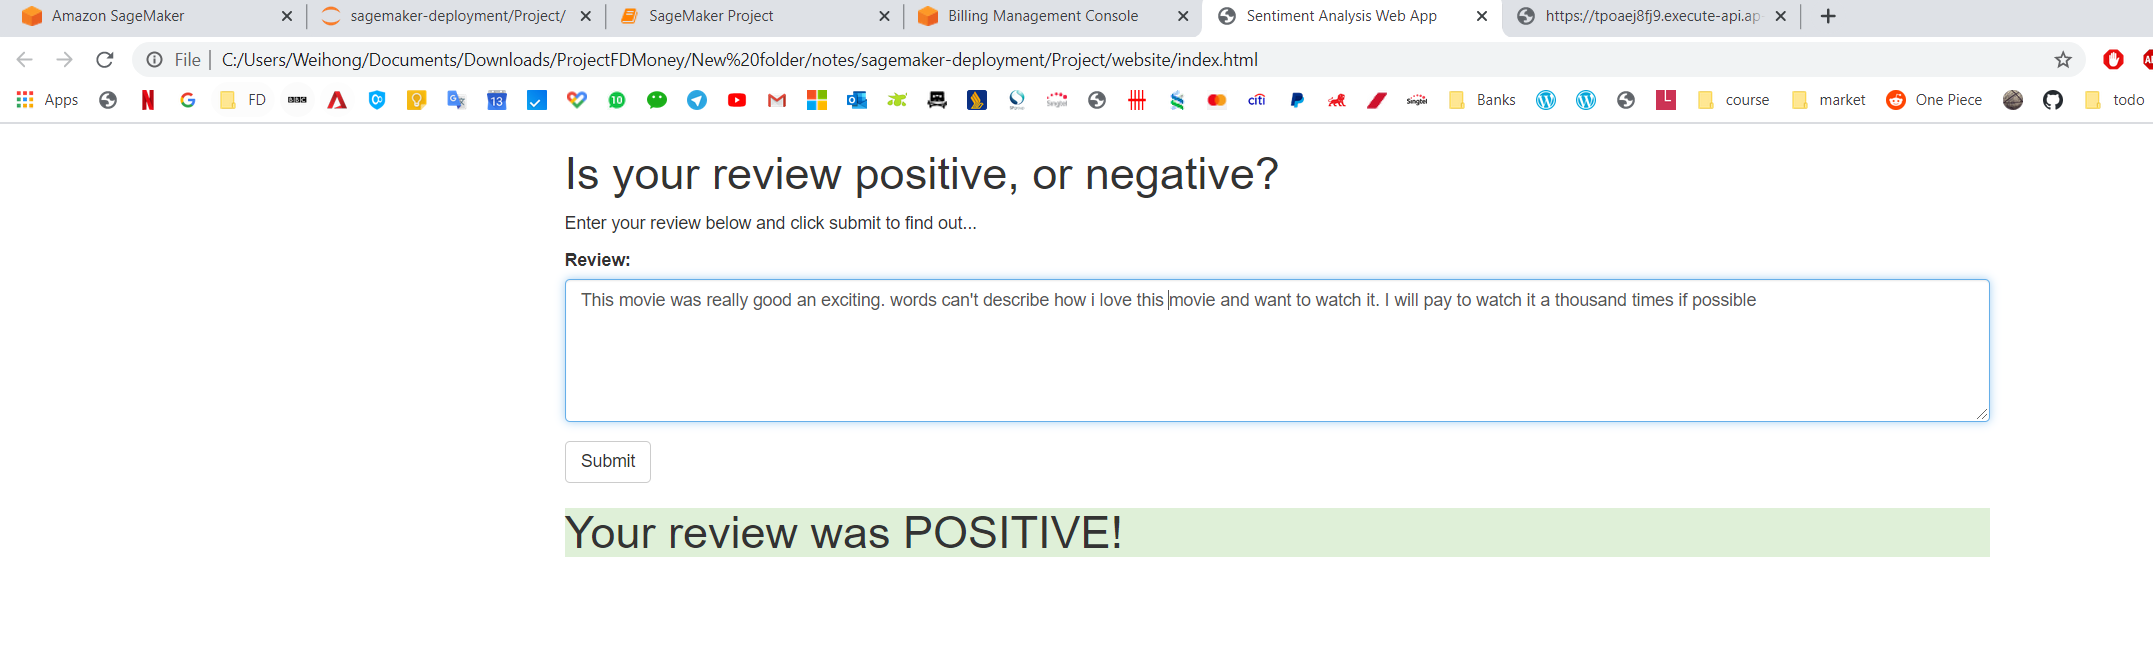

### Delete the endpoint

Remember to always shut down your endpoint if you are no longer using it. You are charged for the length of time that the endpoint is running so if you forget and leave it on you could end up with an unexpectedly large bill.

In [31]:
predictor.delete_endpoint()